In [14]:
%matplotlib inline
from keras.layers import Conv2D, Dense, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential, load_model
from keras.datasets import mnist
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [8]:
MODEL_NAME = 'mnist_cnn'
EPOCHS = 30

In [3]:
# Load the MNIST dataset directly through Keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape data into tensor format
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# Convert training labels to 1-hot binary vectors
binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train)

# Create validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [4]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
__________

In [5]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

In [9]:
stop_callback = EarlyStopping(patience=7, verbose=1)
checkpoint = ModelCheckpoint('{}.h5'.format(MODEL_NAME), verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=5, verbose=1)

H = model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, verbose=1, 
              validation_data=(x_val, y_val), callbacks=[stop_callback, checkpoint, reduce_lr])

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 40s 736us/step - loss: 0.1409 - acc: 0.9561 - val_loss: 0.0412 - val_acc: 0.9853

Epoch 00001: val_loss improved from inf to 0.04123, saving model to mnist_cnn.h5
Epoch 2/30
54000/54000 [==============================] - 40s 736us/step - loss: 0.0708 - acc: 0.9779 - val_loss: 0.0463 - val_acc: 0.9843

Epoch 00002: val_loss did not improve from 0.04123
Epoch 3/30
54000/54000 [==============================] - 40s 741us/step - loss: 0.0571 - acc: 0.9829 - val_loss: 0.0333 - val_acc: 0.9898

Epoch 00003: val_loss improved from 0.04123 to 0.03333, saving model to mnist_cnn.h5
Epoch 4/30
54000/54000 [==============================] - 41s 766us/step - loss: 0.0495 - acc: 0.9845 - val_loss: 0.0238 - val_acc: 0.9930

Epoch 00004: val_loss improved from 0.03333 to 0.02385, saving model to mnist_cnn.h5
Epoch 5/30
54000/54000 [==============================] - 41s 755us/step - loss: 0.0431 -

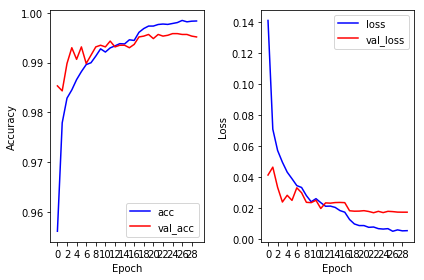

In [10]:
plt.subplot(121)
plt.plot(H.history['acc'], 'b', label='acc')
plt.plot(H.history['val_acc'], 'r', label='val_acc')
plt.xticks(np.arange(len(H.history['acc']), step=2))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(H.history['loss'], 'b', label='loss')
plt.plot(H.history['val_loss'], 'r', label='val_loss')
plt.xticks(np.arange(len(H.history['loss']), step=2))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

In [16]:
# Reload the model with the lowest validation loss
model = load_model('{}.h5'.format(MODEL_NAME))

In [19]:
print('[Training Data]')
loss, acc = model.evaluate(x_train, y_train, verbose=1)
print('Loss: {}\nAccuracy: {}%'.format(loss, acc))

[Training Data]
54000/54000 [==============================] - 10s 192us/step
Loss: 0.0011631143182738992
Accuracy: 0.9997962962962963%


In [20]:
print('[Testing Data]')
loss, acc = model.evaluate(x_test, binarizer.transform(y_test), verbose=1)
print('Loss: {}\nAccuracy: {}%'.format(loss, acc))

[Testing Data]
10000/10000 [==============================] - 2s 196us/step
Loss: 0.013733245430909756
Accuracy: 0.9957%


In [21]:
probs = model.predict(x_test)
preds = probs.argmax(axis=1)

print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       980
          1       1.00      1.00      1.00      1135
          2       1.00      1.00      1.00      1032
          3       1.00      1.00      1.00      1010
          4       0.99      0.99      0.99       982
          5       1.00      1.00      1.00       892
          6       1.00      0.99      0.99       958
          7       0.99      1.00      1.00      1028
          8       1.00      1.00      1.00       974
          9       0.99      0.99      0.99      1009

avg / total       1.00      1.00      1.00     10000



In [22]:
# Label random testing images
while True:
    i = np.random.choice(np.arange(x_test.shape[0]), size=(1,), replace=False)[0]
    sample = x_test[i]
    label = y_test[i]
    print('Image {}: {}'.format(i, label))
    
    prob = model.predict(np.expand_dims(sample, axis=0))
    pred = prob.argmax(axis=1)[0]
    
    img = cv2.cvtColor(sample, cv2.COLOR_GRAY2BGR)
    img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    
    color = (0, 127, 0) if pred == label else (0, 0, 127)
    
    cv2.putText(img, '{}: {:.1f}%'.format(pred, 100*prob.max()), (0, 20), cv2.FONT_HERSHEY_DUPLEX, 0.8, color)
    cv2.imshow('Image {}: {}'.format(i, label), img)
    
    if cv2.waitKey(0) == ord('q'):
        break
    
cv2.destroyAllWindows()

Image 8773: 4
Image 8432: 1
Image 2576: 1
Image 6481: 3
Image 7392: 7
Image 1795: 2
